# Test article question overlap
Having scraped some sample news articles, let's see how well the text of the article overlaps with the questions asked. We'll do this in aggregate (CNN + NYT) and for different audiences (demographics, experience).

### Load data
Let's load the data from the news articles and from the comments.

In [1]:
import pandas as pd
import os
import re
## load articles
nyt_article_dir = '../../data/NYT_scrape/'
nyt_article_files = list(map(lambda x: os.path.join(nyt_article_dir, x), os.listdir(nyt_article_dir)))
nyt_article_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep='\t', index_col=False), nyt_article_files)), axis=0)
article_id_matcher = re.compile('(?<=article_)[0-9a-zA-Z]+(?=\.tsv)')
nyt_article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), nyt_article_files))
nyt_article_data = nyt_article_data.assign(**{
    'article_id' : nyt_article_ids
})
## load comments
nyt_comment_data = pd.read_csv('../../data/nyt_comments/CommentsApril2018.csv', sep=',', index_col=False, usecols=['articleID', 'approveDate', 'commentBody', 'commentType', 'parentID', 'userLocation', 'userID', 'userDisplayName'])
# find questions
from nltk.tokenize import sent_tokenize
question_matcher = re.compile('\?$')
nyt_comment_data = nyt_comment_data.assign(**{
    'comment_questions' : nyt_comment_data.loc[:, 'commentBody'].apply(lambda x: list(filter(lambda y: question_matcher.search(y) is not None, sent_tokenize(x))))
})
# display(nyt_comment_data.head())
# convert to flat question data
nyt_question_data = []
question_cols = ['approveDate', 'articleID', 'commentBody', 'commentType', 'parentID', 'userID', 'userLocation', 'userDisplayName']
for idx_i, data_i in nyt_comment_data.iterrows():
    for question_j in data_i.loc['comment_questions']:
        nyt_question_data.append(pd.Series(data_i.loc[question_cols].append(pd.Series([question_j], index=['comment_question']))))
nyt_question_data = pd.concat(nyt_question_data, axis=1).transpose()
nyt_question_data.rename(columns={'articleID':'article_id'}, inplace=True)
display(nyt_question_data.head())

,approveDate,article_id,commentBody,commentType,parentID,userID,userLocation,userDisplayName,comment_question
0,1524594282,5adf6684068401528a2aa69b,How could the league possibly refuse this offe...,comment,0,4.65667e+07,San Francisco,Christopher Rillo,How could the league possibly refuse this offer?
1,1524593431,5adf6684068401528a2aa69b,Could the cheerleaders join the Actors' Equity...,comment,0,8.19396e+07,"Phoenix, AZ",Stephen,Could the cheerleaders join the Actors' Equity...
2,1524583914,5adf4626068401528a2aa628,Did this remind me of Joyce? <br/><br/>Yes.<br...,comment,0,3.8909e+07,"BK, NY",Dustin R.,Did this remind me of Joyce?
3,1524592934,5adf40d2068401528a2aa619,The Iran nuclear deal does nothing but postpon...,comment,0,4.54286e+07,Rural Tennessee Rural America,Southern Boy,Than what?
4,1524592934,5adf40d2068401528a2aa619,The Iran nuclear deal does nothing but postpon...,comment,0,4.54286e+07,Rural Tennessee Rural America,Southern Boy,Negotiate a new pact?


In [2]:
## CNN articles
cnn_article_dir = '../../data/CNN_articles/cnn/stories/'
cnn_article_files = list(map(lambda x: os.path.join(cnn_article_dir, x), os.listdir(cnn_article_dir)))
cnn_article_data = pd.DataFrame(list(map(lambda x: ' '.join(list(map(lambda x: x.strip(), open(x, 'r').readlines()))), cnn_article_files)),
                                columns=['article_text'])
article_id_matcher = re.compile('[a-z0-9]+(?=\.story)')
cnn_article_ids = list(map(lambda x: article_id_matcher.search(x).group(0), cnn_article_files))
cnn_article_data = cnn_article_data.assign(**{
    'article_id' : cnn_article_ids
})
display(cnn_article_data.head())

,article_text,article_id
0,(CNN) -- It's been a busy few days in the worl...,23f7ab281ef416e1cdcd9c6fc359278a40a6ba34
1,Ten loveable mutts rescued from the streets of...,a8ac73078f8774a5addac799a22d0634278e79d1
2,Ken Henggeler poured his grief into the thing ...,022713fd20ac0ffd0ddccec6d9389beedd681893
3,Tokyo (CNN) -- Japan's prime minister vowed to...,d62d6364625d1522c55024486ec25851687935e3
4,(CNN) -- The leadership of North Korea appeare...,911597eecfe5d00d39de94f17c2a8400fcb4b994


In [3]:
## load questions
import pandas as pd
import re
cnn_question_file = '../../data/CNN_articles/cnn/newsqa-data-v1/newsqa-data-v1.csv'
full_cnn_question_data = pd.read_csv(cnn_question_file, sep=',', index_col=False, usecols=['story_id', 'question', 'is_answer_absent', 'is_question_bad'])
full_cnn_question_data.rename(columns={'story_id' : 'article_id'}, inplace=True)
# get article IDs
cnn_article_id_matcher = re.compile('[0-9a-zA-Z]+(?=\.story)')
full_cnn_question_data = full_cnn_question_data.assign(**{
    'article_id' : full_cnn_question_data.loc[:, 'article_id'].apply(lambda x: cnn_article_id_matcher.search(x).group(0))
})
# get rid of unclear questions
# NOTE: we may need the different "bad" ratings later when testing word overlap
full_cnn_question_data = full_cnn_question_data[full_cnn_question_data.loc[:, 'is_question_bad']!='?']
full_cnn_question_data = full_cnn_question_data.assign(**{'is_question_bad' : full_cnn_question_data.loc[:, 'is_question_bad'].astype(float)})
# remove bad questions
cnn_question_data = full_cnn_question_data[(full_cnn_question_data.loc[:, 'is_answer_absent']==0.) &
                                           (full_cnn_question_data.loc[:, 'is_question_bad']==0.)]
display(cnn_question_data.head())

,article_id,question,is_answer_absent,is_question_bad
0,42d01e187213e86f5fe617fe32e716ff7fa3afc4,What was the amount of children murdered?,0.0,0.0
1,c48228a52f26aca65c31fad273e66164f047f292,Where was one employee killed?,0.0,0.0
2,c65ed85800e4535f4bbbfa2c34d7d9630358d303,who did say South Africa did not issue a visa ...,0.0,0.0
3,0cf66b646e9b32076513c050edf32a799200c3c2,How many years old was the businessman?,0.0,0.0
4,13012604e3203c18df09289dfedd14cde67cf40b,What frightened the families?,0.0,0.0


Combine article, question data.

In [4]:
import numpy as np
# combine data, remove null articles
## NYT data
nyt_article_question_data = pd.merge(nyt_article_data, nyt_question_data, on='article_id')
nyt_article_question_data = nyt_article_question_data[~nyt_article_question_data.loc[:, 'text'].apply(lambda x: type(x) is float and np.isnan(x))]
print(f'NYT data: {nyt_article_question_data.loc[:, "article_id"].nunique()} unique articles, {nyt_article_question_data.shape[0]} questions')
# display(nyt_article_question_data.head())
## CNN data
cnn_article_question_data = pd.merge(cnn_question_data, cnn_article_data, on='article_id')
cnn_article_question_data = cnn_article_question_data[~cnn_article_question_data.loc[:, 'article_text'].apply(lambda x: type(x) is float and np.isnan(x))]
print(f'CNN data: {cnn_article_question_data.loc[:, "article_id"].nunique()} unique articles, {cnn_article_question_data.shape[0]} questions')
# display(nyt_article_question_data.head())

NYT data: 396 unique articles, 35374 questions
CNN data: 11852 unique articles, 63672 questions


In [8]:
## clean question data
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
nyt_article_question_data = nyt_article_question_data.assign(**{
    'question_tokens' : nyt_article_question_data.loc[:, 'comment_question'].apply(lambda x: tokenizer.tokenize(x))
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'question_tokens' : cnn_article_question_data.loc[:, 'question'].apply(lambda x: tokenizer.tokenize(x))
})
min_question_len = 5
nyt_article_question_data = nyt_article_question_data[nyt_article_question_data.loc[:, 'question_tokens'].apply(lambda x: len(x) >= min_question_len)]
cnn_article_question_data = cnn_article_question_data[cnn_article_question_data.loc[:, 'question_tokens'].apply(lambda x: len(x) >= min_question_len)]
print(f'NYT: {nyt_article_question_data.shape[0]} clean questions')
print(f'CNN: {cnn_article_question_data.shape[0]} clean questions')
## clean article data
nyt_article_question_data = nyt_article_question_data.assign(**{
    'article_tokens' : nyt_article_question_data.loc[:, 'text'].apply(lambda x: tokenizer.tokenize(x))
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'article_tokens' : cnn_article_question_data.loc[:, 'article_text'].apply(lambda x: tokenizer.tokenize(x))
})
nyt_article_question_data = nyt_article_question_data.assign(**{
    'publisher' : 'NYT'
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'publisher' : 'CNN'
})
nyt_article_question_data = nyt_article_question_data.assign(**{
    'dummy_comment_id' : list(range(nyt_article_question_data.shape[0]))
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'dummy_comment_id' : list(range(cnn_article_question_data.shape[0]))
})
## save for easier handling
nyt_article_question_data.to_csv('../../data/nyt_comments/April2018_article_question_data.tsv', sep='\t', index=False)
cnn_article_question_data.to_csv('../../data/CNN_articles/cnn/article_question_data.tsv', sep='\t', index=False)

NYT: 31440 clean questions
CNN: 60401 clean questions


### Test overlap: aggregate
In aggregate, how much do the questions overlap with the article content? 

We'll start simple and compute BLEU scores, i.e. n-gram overlap.

In [6]:
## testing BLEU score with unigrams
from nltk.translate.bleu_score import sentence_bleu
test_sents_1 = ['is this cheese fresh ?'.split(' '), 'is this salad fresh at all ? '.split(' ')]
test_sent_2 = 'this cheese is the most fresh . it is delicious .'.split(' ')
# only weight 1-grams
bleu_weights = [1.0, 0., 0., 0.]
for test_sent in test_sents_1:
    print(f'sent = <{" ".join(test_sent)}>')
    test_score = sentence_bleu([test_sent], test_sent_2, weights=bleu_weights)
    print(test_score)

sent = <is this cheese fresh ?>
0.36363636363636365
sent = <is this salad fresh at all ? >
0.2727272727272727


/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider 

Let's test the BLEU-1 scores for both question sets.

In [7]:
from nltk.translate.bleu_score import sentence_bleu
from pandarallel import pandarallel
JOBS=10
pandarallel.initialize(nb_workers=JOBS)
# bleu_weight_list = [[1.0, 0., 0., 0.], [0.5, 0.5, 0., 0.]]
# bleu_score_names = ['article_question_bleu_1', 'article_question_bleu_2']
bleu_weights = [1.0, 0., 0., 0.]
def compute_text_bleu(txt_1, txt_2, bleu_weights):
    score = sentence_bleu([txt_1], txt_2, weights=bleu_weights)
    return score
nyt_article_question_data = nyt_article_question_data.assign(**{
    'article_question_bleu' : nyt_article_question_data.parallel_apply(lambda x: compute_text_bleu(x.loc['question_tokens'], x.loc['article_tokens'], bleu_weights=bleu_weights), axis=1)
})
cnn_article_question_data = cnn_article_question_data.assign(**{
    'article_question_bleu' : cnn_article_question_data.parallel_apply(lambda x: compute_text_bleu(x.loc['question_tokens'], x.loc['article_tokens'], bleu_weights=bleu_weights), axis=1)
})

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


How different are the distributions of question overlap between user-generated questions (NYT) and "clean" questions (CNN)?

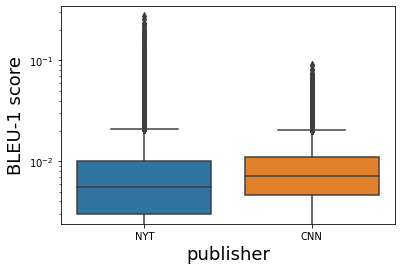

NYT median score = 5.579E-03
CNN median score = 7.102E-03
test stat = 776786017.500 (p=0.000E+00)


In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plot_question_data = pd.concat(
    [
        nyt_article_question_data.loc[:, ['article_id', 'article_question_bleu', 'dummy_comment_id', 'publisher']],
        cnn_article_question_data.loc[:, ['article_id', 'article_question_bleu', 'dummy_comment_id', 'publisher']],
    ], axis=0
)
sns.boxplot(x='publisher', y='article_question_bleu', data=plot_question_data)
plt.xlabel('publisher', fontsize=18)
plt.ylabel('BLEU-1 score', fontsize=18)
plt.yscale('log')
plt.show()
## is difference significant?
print('NYT median score = %.3E'%(nyt_article_question_data.loc[:, 'article_question_bleu'].median()))
print('CNN median score = %.3E'%(cnn_article_question_data.loc[:, 'article_question_bleu'].median()))
from scipy.stats import mannwhitneyu
test_stat, p_val = mannwhitneyu(nyt_article_question_data.loc[:, 'article_question_bleu'].values,
                                cnn_article_question_data.loc[:, 'article_question_bleu'].values)
print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

No surprise here: the questions from CNN have more overlap with the articles.

Let's see the questions with the most overlap.

In [10]:
print('*~*~*~* NYT *~*~*~*')
max_text_print_len = 300
for idx_i, data_i in nyt_article_question_data.drop_duplicates('article_id').sort_values('article_question_bleu', inplace=False, ascending=False).head(5).iterrows():
    print(f'idx={idx_i}')
    print('BLEU score = %.3f'%(data_i.loc["article_question_bleu"]))
    print(f'text = {data_i.loc["text"][:max_text_print_len]}...')
    print(f'question = {data_i.loc["comment_question"]}')
print('*~*~*~* CNN *~*~*~*')
for idx_i, data_i in cnn_article_question_data.drop_duplicates('article_id').sort_values('article_question_bleu', inplace=False, ascending=False).head(5).iterrows():
    print(f'idx={idx_i}')
    print('BLEU score = %.3f'%(data_i.loc["article_question_bleu"]))
    print(f'text = {data_i.loc["article_text"][:max_text_print_len]}...')
    print(f'question = {data_i.loc["question"]}')
# display(nyt_article_question_data.sort_values('article_question_bleu', inplace=False, ascending=False).head(5).loc[:, ['text', 'comment_question', 'article_question_bleu']])
# display(cnn_article_question_data.sort_values('article_question_bleu', inplace=False, ascending=False).head(5).loc[:, ['article_text', 'question', 'article_question_bleu']])

*~*~*~* NYT *~*~*~*
idx=28597
BLEU score = 0.171
text = “We don’t completely blame Facebook. The germs are ours, but Facebook is the wind, you know?” HARINDRA DISSANAYAKE , a presidential adviser in Sri Lanka.  ...
question = Lots of people are blaming Facebook (and other platforms) when really all it did was hold a mirror up, what's your feed, groups and comments say about you?
idx=12950
BLEU score = 0.115
text = “This is the nightmare scenario. Everybody figured he’d just hang in there till after the election.” THOMAS M. DAVIS III , a former Republican representative from Virginia, on the fallout from the surprise announcement by Speaker Paul D. Ryan that he won’t seek re-election to Congress this fall.  ...
question = Won't Ryan will get a taxpayer-paid pension—some $70,00 per year—for his disservice to the country?
idx=19092
BLEU score = 0.087
text = What is the most interesting topic you have learned about in school? Why did it appeal to you? In “ Pop-Ups Offer Classes on Today’s 

The high-overlap comments often contain names (`Facebook`), specific wording from the article (`sprayed`) and direct quotes (`<br/>`).

### Extract commenter metadata
Let's now extract important background information from the commenters and determine whether certain demographics tend to ask more/less relevant questions, based on overlap.

In [11]:
import data_helpers
from importlib import reload
reload(data_helpers)
from data_helpers import load_name_gender_data
name_data_dir = '../../data/meta_data/baby_names/'
name_gender_label_data = load_name_gender_data(name_data_dir)
name_gender_label_data.rename(columns={'name' : 'user_first_name'}, inplace=True)
# remove names with only two letters!! no ambiguity
min_name_len = 3
name_gender_label_data = name_gender_label_data[name_gender_label_data.loc[:, 'user_first_name'].apply(len) >= min_name_len]

/home/ianbstew/audience_aware_NLP/scripts/data_processing/data_helpers.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values('count_pct', inplace=True, ascending=False)


In [12]:
nyt_article_question_data = pd.read_csv('../../data/nyt_comments/April2018_article_question_data.tsv', sep='\t', index_col=False)
cnn_article_question_data = pd.read_csv('../../data/CNN_articles/cnn/article_question_data.tsv', sep='\t', index_col=False)

In [13]:
## combine with comment data
# extract first names from comment user names
import re
from data_helpers import extract_name
def add_labels_to_names(data, name_label_data, label_var='gender'):
    camel_matcher = re.compile('[a-z]+(?=[A-Z])')
    data = data.assign(**{
        'user_first_name' : data.loc[:, 'userDisplayName'].apply(lambda x: extract_name(str(x), camel_matcher))
    })
    # add gender lol
    if(label_var in data.columns):
        data.drop(label_var, axis=1, inplace=True)
    data = pd.merge(data, name_label_data, on='user_first_name', how='left')
    data.fillna(value={label_var : 'UNK'}, inplace=True)
    # display(comment_article_data.loc[:, ['user_first_name', 'gender']])
    return data
nyt_article_question_data = add_labels_to_names(nyt_article_question_data, name_gender_label_data, label_var='gender')
# get top names per gender
for label_i, data_i in nyt_article_question_data.groupby('gender'):
    print(f'top names for label={label_i}')
    print(data_i.loc[:, 'user_first_name'].value_counts().iloc[:10])

top names for label=F
susan        164
lisa          91
mary          89
karen         85
ana           85
elizabeth     71
linda         66
ann           58
azalea        56
barbara       55
Name: user_first_name, dtype: int64
top names for label=M
john       561
david      335
mark       294
tom        280
robert     272
michael    261
mike       232
jim        219
steve      214
paul       213
Name: user_first_name, dtype: int64
top names for label=UNK
ed              100
j                85
mythreecents     83
concerned        65
c                63
me               60
a                56
vts              56
boregard         55
bmusnsoil        54
Name: user_first_name, dtype: int64


Great! Now let's do geography.

In [14]:
print(nyt_article_question_data.loc[:, 'userLocation'].value_counts().head(10))
unique_locations = nyt_article_question_data.loc[:, 'userLocation'].unique()
ambig_locations = set(['CA', 'NE'])
unique_locations = pd.Series(list(set(unique_locations) - ambig_locations))

NYC              1125
New York          843
California        527
Chicago           506
NY                408
San Francisco     365
Los Angeles       362
Seattle           340
Boston            325
USA               324
Name: userLocation, dtype: int64


In [15]:
## let's do some geocoding
import geocoder
def geocode_country(text):
    text_loc_country = 'UNK'
    try:
        text_loc = geocoder.osm(text, method='geocode')
        text_loc_data = text_loc.response.json()
        if(len(text_loc_data) > 0):
            text_loc_country = text_loc_data[0]['address']['country_code']
    except Exception as e:
        print(f'geocoding error {e}')
    return text_loc_country
test = 'Chicago'
test_country = geocode_country(test)
print(test_country)

us


In [16]:
from tqdm import tqdm
tqdm.pandas()
unique_location_countries = unique_locations.progress_apply(geocode_country)

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
  4%|▍         | 186/4438 [01:33<35:32,  1.99it/s]

geocoding error 'country_code'


  4%|▍         | 195/4438 [01:37<35:23,  2.00it/s]

geocoding error 'country_code'


 10%|▉         | 434/4438 [03:41<34:04,  1.96it/s]

geocoding error 'country_code'


 39%|███▉      | 1724/4438 [14:43<23:13,  1.95it/s]

geocoding error Coords are not within the world's geographical boundary


 46%|████▌     | 2032/4438 [17:20<19:36,  2.04it/s]

geocoding error 'country_code'


 48%|████▊     | 2124/4438 [18:06<19:40,  1.96it/s]

geocoding error 'country_code'


 94%|█████████▍| 4186/4438 [35:48<02:05,  2.01it/s]

geocoding error 'country_code'


100%|██████████| 4438/4438 [37:57<00:00,  1.95it/s]


In [17]:
## which countries had the most coverage?
print(unique_location_countries.value_counts().head(10))

us     3180
UNK     276
ca      141
gb      130
fr       69
au       48
de       38
it       30
co       26
in       24
dtype: int64


In [18]:
## label each author by region
author_location_data = pd.DataFrame([unique_locations, unique_location_countries], index=['userLocation', 'user_country']).transpose()
print(author_location_data)
if('user_country' not in nyt_article_question_data.columns):
    nyt_article_question_data = pd.merge(nyt_article_question_data, author_location_data, on='userLocation')
from collections import defaultdict
location_region_lookup = defaultdict(lambda : 'UNK')
# country-region codes
location_region_lookup.update(
    {'ad': 'europe', 'ae': 'asia', 'af': 'asia', 'ag': 'north_america', 'ai': 'north_america', 'al': 'europe', 'am': 'asia', 'an': 'north_america', 'ao': 'africa', 'ap': 'asia', 'aq': 'antarctica', 'ar': 'south_america', 'as': 'oceania', 'at': 'europe', 'au': 'oceania', 'aw': 'north_america', 'ax': 'europe', 'az': 'asia', 'ba': 'europe', 'bb': 'north_america', 'bd': 'asia', 'be': 'europe', 'bf': 'africa', 'bg': 'europe', 'bh': 'asia', 'bi': 'africa', 'bj': 'africa', 'bl': 'north_america', 'bm': 'north_america', 'bn': 'asia', 'bo': 'south_america', 'br': 'south_america', 'bs': 'north_america', 'bt': 'asia', 'bv': 'antarctica', 'bw': 'africa', 'by': 'europe', 'bz': 'north_america', 'ca': 'north_america', 'cc': 'asia', 'cd': 'africa', 'cf': 'africa', 'cg': 'africa', 'ch': 'europe', 'ci': 'africa', 'ck': 'oceania', 'cl': 'south_america', 'cm': 'africa', 'cn': 'asia', 'co': 'south_america', 'cr': 'north_america', 'cu': 'north_america', 'cv': 'africa', 'cx': 'asia', 'cy': 'asia', 'cz': 'europe', 'de': 'europe', 'dj': 'africa', 'dk': 'europe', 'dm': 'north_america', 'do': 'north_america', 'dz': 'africa', 'ec': 'south_america', 'ee': 'europe', 'eg': 'africa', 'eh': 'africa', 'er': 'africa', 'es': 'europe', 'et': 'africa', 'eu': 'europe', 'fi': 'europe', 'fj': 'oceania', 'fk': 'south_america', 'fm': 'oceania', 'fo': 'europe', 'fr': 'europe', 'fx': 'europe', 'ga': 'africa', 'gb': 'europe', 'gd': 'north_america', 'ge': 'asia', 'gf': 'south_america', 'gg': 'europe', 'gh': 'africa', 'gi': 'europe', 'gl': 'north_america', 'gm': 'africa', 'gn': 'africa', 'gp': 'north_america', 'gq': 'africa', 'gr': 'europe', 'gs': 'antarctica', 'gt': 'north_america', 'gu': 'oceania', 'gw': 'africa', 'gy': 'south_america', 'hk': 'asia', 'hm': 'antarctica', 'hn': 'north_america', 'hr': 'europe', 'ht': 'north_america', 'hu': 'europe', 'id': 'asia', 'ie': 'europe', 'il': 'asia', 'im': 'europe', 'in': 'asia', 'io': 'asia', 'iq': 'asia', 'ir': 'asia', 'is': 'europe', 'it': 'europe', 'je': 'europe', 'jm': 'north_america', 'jo': 'asia', 'jp': 'asia', 'ke': 'africa', 'kg': 'asia', 'kh': 'asia', 'ki': 'oceania', 'km': 'africa', 'kn': 'north_america', 'kp': 'asia', 'kr': 'asia', 'kw': 'asia', 'ky': 'north_america', 'kz': 'asia', 'la': 'asia', 'lb': 'asia', 'lc': 'north_america', 'li': 'europe', 'lk': 'asia', 'lr': 'africa', 'ls': 'africa', 'lt': 'europe', 'lu': 'europe', 'lv': 'europe', 'ly': 'africa', 'ma': 'africa', 'mc': 'europe', 'md': 'europe', 'me': 'europe', 'mf': 'north_america', 'mg': 'africa', 'mh': 'oceania', 'mk': 'europe', 'ml': 'africa', 'mm': 'asia', 'mn': 'asia', 'mo': 'asia', 'mp': 'oceania', 'mq': 'north_america', 'mr': 'africa', 'ms': 'north_america', 'mt': 'europe', 'mu': 'africa', 'mv': 'asia', 'mw': 'africa', 'mx': 'north_america', 'my': 'asia', 'mz': 'africa', 'na': 'africa', 'nc': 'oceania', 'ne': 'africa', 'nf': 'oceania', 'ng': 'africa', 'ni': 'north_america', 'nl': 'europe', 'no': 'europe', 'np': 'asia', 'nr': 'oceania', 'nu': 'oceania', 'nz': 'oceania', 'om': 'asia', 'pa': 'north_america', 'pe': 'south_america', 'pf': 'oceania', 'pg': 'oceania', 'ph': 'asia', 'pk': 'asia', 'pl': 'europe', 'pm': 'north_america', 'pn': 'oceania', 'pr': 'north_america', 'ps': 'asia', 'pt': 'europe', 'pw': 'oceania', 'py': 'south_america', 'qa': 'asia', 're': 'africa', 'ro': 'europe', 'rs': 'europe', 'ru': 'europe', 'rw': 'africa', 'sa': 'asia', 'sb': 'oceania', 'sc': 'africa', 'sd': 'africa', 'se': 'europe', 'sg': 'asia', 'sh': 'africa', 'si': 'europe', 'sj': 'europe', 'sk': 'europe', 'sl': 'africa', 'sm': 'europe', 'sn': 'africa', 'so': 'africa', 'sr': 'south_america', 'st': 'africa', 'sv': 'north_america', 'sy': 'asia', 'sz': 'africa', 'tc': 'north_america', 'td': 'africa', 'tf': 'antarctica', 'tg': 'africa', 'th': 'asia', 'tj': 'asia', 'tk': 'oceania', 'tl': 'asia', 'tm': 'asia', 'tn': 'africa', 'to': 'oceania', 'tr': 'europe', 'tt': 'north_america', 'tv': 'oceania', 'tw': 'asia', 'tz': 'africa', 'ua': 'europe', 'ug': 'africa', 'um': 'oceania', 'us': 'north_america', 'uy': 'south_america', 'uz': 'asia', 'va': 'europe', 'vc': 'north_america', 've': 'south_america', 'vg': 'north_america', 'vi': 'north_america', 'vn': 'asia', 'vu': 'oceania', 'wf': 'oceania', 'ws': 'oceania', 'ye': 'asia', 'yt': 'africa', 'za': 'africa', 'zm': 'africa', 'zw': 'africa', 'UNK' : 'UNK'}
)
nyt_article_question_data = nyt_article_question_data.assign(**{
    'user_region' : nyt_article_question_data.loc[:, 'user_country'].apply(lambda x: location_region_lookup[x])
})
print(nyt_article_question_data.loc[:, 'user_country'].value_counts().head(10))
print(nyt_article_question_data.loc[:, 'user_region'].value_counts().head(10))

          userLocation user_country
0                  NaN           it
1     Spring Green, WI           us
2      Colorado Trails           us
3       Coldstream, BC           ca
4       Harrisburg, PA           us
...                ...          ...
4433        urbana, il           us
4434         The Coast           gb
4435         Pasco, WA           us
4436             D. C.           us
4437      Williamsburg           us

[4438 rows x 2 columns]
us     25423
UNK     1015
ca       959
gb       583
fr       396
au       276
co       231
it       219
de       171
be       130
Name: user_country, dtype: int64
north_america    26645
europe            2138
UNK               1017
asia               543
south_america      397
oceania            338
africa             206
Name: user_region, dtype: int64


Let's get the last useful audience cue, i.e. experience.

In [19]:
## load combined comment data
import pandas as pd
import re
import os
from datetime import datetime
comment_data_file_matcher = re.compile('Comments.*csv')
data_dir = '../../data/nyt_comments/'
comment_data_files = list(filter(lambda x: comment_data_file_matcher.search(x) is not None, os.listdir(data_dir)))
comment_data_files = list(map(lambda x: os.path.join(data_dir, x), comment_data_files))
# print(comment_data_files)
# load, combine commeant data
month_matcher = re.compile('[A-Z][a-z]+(?=[0-9])')
year_matcher = re.compile('[0-9]{4}')
months = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_lookup = dict(zip(months, range(1,len(months)+1)))
combined_comment_data = []
for comment_data_file_i in comment_data_files:
    comment_data_i = pd.read_csv(comment_data_file_i, sep=',', index_col=False, usecols=['approveDate', 'commentBody', 'commentID', 'commentType', 'userDisplayName', 'userID', 'sectionName', 'articleID'])
    comment_data_date_i = [month_lookup[month_matcher.search(comment_data_file_i).group(0)], int(year_matcher.search(comment_data_file_i).group(0))]
    comment_data_date_i = datetime(day=1, month=comment_data_date_i[0], year=comment_data_date_i[1])
    comment_data_i = comment_data_i.assign(**{'comment_time_period' : comment_data_date_i})
    combined_comment_data.append(comment_data_i)
combined_comment_data = pd.concat(combined_comment_data, axis=0)
# add article data lol
article_data_file_matcher = re.compile('Articles.*csv')
article_data_files = list(filter(lambda x: article_data_file_matcher.search(x) is not None, os.listdir(data_dir)))
article_data_files = list(map(lambda x: os.path.join(data_dir, x), article_data_files))
article_data = pd.concat(list(map(lambda x: pd.read_csv(x, sep=',', index_col=False, usecols=['articleID', 'headline', 'snippet', 'pubDate']), article_data_files)))
combined_comment_data = pd.merge(combined_comment_data, article_data, on='articleID')
# fix data types
# article_date_format = '2018-04-21 18:30:10'
article_date_format = '%Y-%m-%d %H:%M:%S'
combined_comment_data = combined_comment_data.assign(**{
    'userID' : combined_comment_data.loc[:, 'userID'].astype(int),
    'commentID' : combined_comment_data.loc[:, 'commentID'].astype(int),
    'approveDate': combined_comment_data.loc[:, 'approveDate'].apply(lambda x: datetime.fromtimestamp(x)),
    'pubDate': combined_comment_data.loc[:, 'pubDate'].apply(lambda x: datetime.strptime(x, article_date_format)),
})
print(combined_comment_data.shape[0])
display(combined_comment_data.head())

<ipython-input-19-4ecd11e1196e>:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  combined_comment_data = pd.concat(combined_comment_data, axis=0)


2171181


,approveDate,articleID,commentBody,commentID,commentType,comment_time_period,sectionName,userDisplayName,userID,headline,pubDate,snippet
0,2017-02-02 15:02:21,58927e0495d0e0392607e1b3,ANY anti Trump propaganda from Gaga and my TV ...,21332974,comment,2017-02-01,Pro Football,vilonia,68372461,N.F.L. vs. Politics Has Been Battle All Season...,2017-02-02 00:26:16,Despite the national tumult over immigration s...
1,2017-02-02 15:02:21,58927e0495d0e0392607e1b3,ANY anti Trump propaganda from Gaga and my TV ...,21332974,comment,2017-02-01,Pro Football,vilonia,68372461,N.F.L. vs. Politics Has Been Battle All Season...,2017-02-02 00:26:16,Despite the national tumult over immigration s...
2,2017-02-02 12:07:51,58927e0495d0e0392607e1b3,"I'll not watch the SB, nor the grammys or osca...",21332861,comment,2017-02-01,Pro Football,Joe Schultz,73635333,N.F.L. vs. Politics Has Been Battle All Season...,2017-02-02 00:26:16,Despite the national tumult over immigration s...
3,2017-02-02 12:07:51,58927e0495d0e0392607e1b3,"I'll not watch the SB, nor the grammys or osca...",21332861,comment,2017-02-01,Pro Football,Joe Schultz,73635333,N.F.L. vs. Politics Has Been Battle All Season...,2017-02-02 00:26:16,Despite the national tumult over immigration s...
4,2017-02-02 12:07:20,58927e0495d0e0392607e1b3,"NFL's going to do another ""in-your-face, Ameri...",21332686,comment,2017-02-01,Pro Football,WilliamPenn2,61340508,N.F.L. vs. Politics Has Been Battle All Season...,2017-02-02 00:26:16,Despite the national tumult over immigration s...


In [20]:
## define date cutoff
from datetime import datetime
data_year_cutoff = 2018
data_month_cutoff = 4
data_day_cutoff = 1
comment_date_cutoff = datetime(year=data_year_cutoff, month=data_month_cutoff, day=data_day_cutoff)
cutoff_combined_comment_data = combined_comment_data[combined_comment_data.loc[:, 'approveDate'] < comment_date_cutoff]
## define cutoff for experienced users
import numpy as np
experienced_author_cutoff_pct = 90
author_comment_counts = np.log(cutoff_combined_comment_data.loc[:, 'userID'].value_counts())
experienced_author_cutoff = np.percentile(author_comment_counts, experienced_author_cutoff_pct)
print(f'authors with >=exp({experienced_author_cutoff}) posts are experienced')
author_experience_data = author_comment_counts.reset_index(name='comment_count').rename(columns={'index':'userID'})
experience_bins = [experienced_author_cutoff]
author_experience_data = author_experience_data.assign(**{
    'author_experienced' : np.digitize(author_experience_data.loc[:, 'comment_count'], bins=experience_bins)
})
display(author_experience_data.head())
print(author_experience_data.loc[:, 'author_experienced'].value_counts())

authors with >=exp(2.5649493574615367) posts are experienced


,userID,comment_count,author_experienced
0,67892453,8.670601,1
1,11228992,8.188411,1
2,61986282,8.062118,1
3,64679318,7.945555,1
4,37475504,7.757479,1


0    200841
1     23147
Name: author_experienced, dtype: int64


In [21]:
## add to existing data
# if('author_experienced' not in nyt_article_question_data.columns):
if('author_experienced' in nyt_article_question_data.columns):
    nyt_article_question_data.drop(['author_experienced', 'comment_count'], axis=1, inplace=True)
nyt_article_question_data = pd.merge(nyt_article_question_data, author_experience_data, on='userID')
print(nyt_article_question_data.loc[:, 'author_experienced'].value_counts())

1    22945
0     6053
Name: author_experienced, dtype: int64


### Compare question-answer overlap for different reader groups
Let's see whether certain audiences tend to pose questions that overlap more with the article content.

In [22]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from itertools import product
def test_median_diff_label_combos(data, label_var, test_var):
    labels = data.loc[:, label_var].unique()
    label_combos = [(label_i, label_j) for i, label_i in enumerate(labels) for j, label_j in enumerate(labels[(i+1):])]
    for label_i, label_j in label_combos:
        print(f'testing {label_i} vs. {label_j}')
        label_vals_i = data[data.loc[:, label_var]==label_i].loc[:, test_var].values
        label_vals_j = data[data.loc[:, label_var]==label_j].loc[:, test_var].values
        median_diff_i_j = np.median(label_vals_i) - np.median(label_vals_j)
        test_stat, p_val = mannwhitneyu(label_vals_i, label_vals_j)
        print(f'{label_i} vs. {label_j} has median difference {median_diff_i_j} with test stat = %.3f (p=%.3E)'%(test_stat, p_val))

testing M vs. F
M vs. F has median difference 5.262438041649629e-06 with test stat = 25480363.000 (p=2.604E-01)
testing M vs. UNK
M vs. UNK has median difference 0.000115768307061794 with test stat = 72211899.500 (p=1.455E-01)
testing F vs. UNK
F vs. UNK has median difference 0.00011050586902014436 with test stat = 31701386.000 (p=4.405E-01)


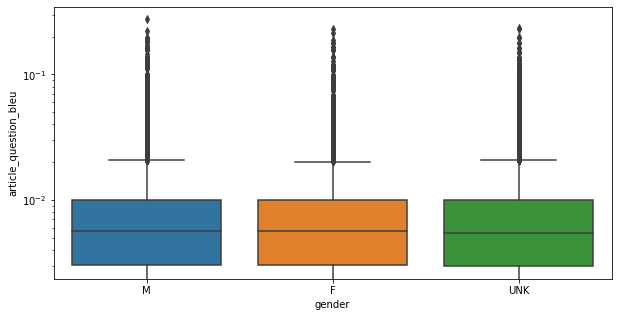

In [23]:
## gender
test_median_diff_label_combos(nyt_article_question_data, 'gender', 'article_question_bleu')
plt.figure(figsize=(10,5))
sns.boxplot(x='gender', y='article_question_bleu', data=nyt_article_question_data)
plt.yscale('log')
plt.show()

testing north_america vs. europe
north_america vs. europe has median difference 0.0002915769781172044 with test stat = 23562114.000 (p=1.263E-01)
testing north_america vs. UNK
north_america vs. UNK has median difference 0.00034259154158562764 with test stat = 11111978.000 (p=1.130E-02)
testing north_america vs. oceania
north_america vs. oceania has median difference 0.00037500430841346834 with test stat = 3651732.500 (p=3.796E-02)
testing north_america vs. asia
north_america vs. asia has median difference 0.0003054750346336973 with test stat = 5786391.500 (p=1.067E-01)
testing north_america vs. africa
north_america vs. africa has median difference 0.0007549485959797439 with test stat = 2099555.000 (p=2.440E-02)
testing north_america vs. south_america
north_america vs. south_america has median difference -8.397061028640306e-05 with test stat = 4456055.500 (p=2.021E-01)
testing europe vs. UNK
europe vs. UNK has median difference 5.101456346842323e-05 with test stat = 881031.500 (p=1.142E

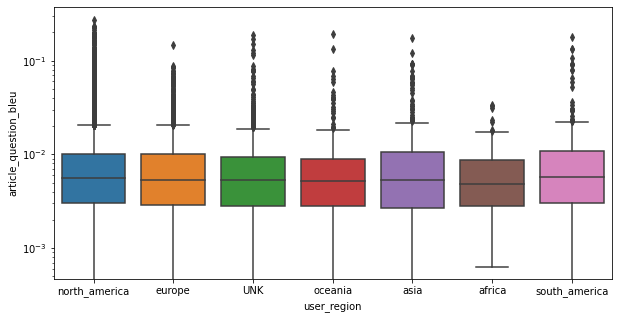

In [24]:
# geography
test_median_diff_label_combos(nyt_article_question_data, 'user_region', 'article_question_bleu')
plt.figure(figsize=(10,5))
sns.boxplot(x='user_region', y='article_question_bleu', data=nyt_article_question_data)
plt.yscale('log')
plt.show()

testing 1 vs. 0
1 vs. 0 has median difference 0.00020685817334080685 with test stat = 68305403.500 (p=2.478E-02)


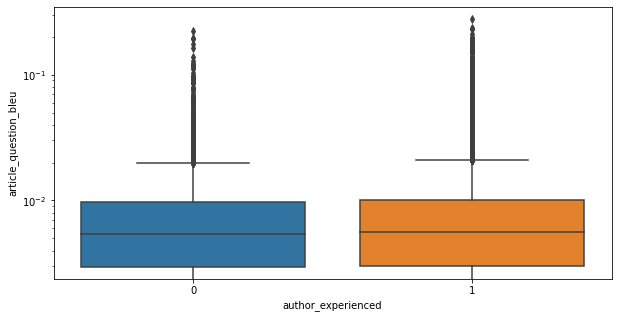

correlation between comments, question overlap = 0.016 (p=6.319E-03)


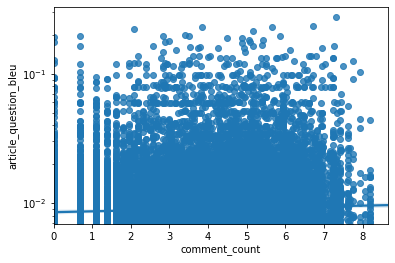

In [26]:
# experience
test_median_diff_label_combos(nyt_article_question_data, 'author_experienced', 'article_question_bleu')
plt.figure(figsize=(10,5))
sns.boxplot(x='author_experienced', y='article_question_bleu', data=nyt_article_question_data)
plt.yscale('log')
plt.show()
## curiosity: any correlation between integer value for experience
from scipy.stats import spearmanr
correl, p_val = spearmanr(nyt_article_question_data.loc[:, 'comment_count'], 
                          nyt_article_question_data.loc[:, 'article_question_bleu'])
print('correlation between comments, question overlap = %.3f (p=%.3E)'%(correl, p_val))
sns.regplot(x='comment_count', y='article_question_bleu', data=nyt_article_question_data)
plt.yscale('log')
plt.show()

OK! So overall we've learned:

- no gender differences
- mild location differences (US has slightly higher overlap than UNK, possibly more attention to detail by local people?)
- mild experience differences (high-experience authors have weakly higher overlap than low-experience authors; we may need per-section experience)